In [2]:
import energyflow as ef
import energyflow
from energyflow.emd import emd
from energyflow.datasets import mod

import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import modplot
import mod_io
import utils

save_plots = False

In [3]:
# read in the dataset
cms = mod.load(dataset='cms', amount=1.0, store_pfcs=True)
print("Read in {} jets.".format(len(cms)))

Read in 1785625 jets.


## Individual Jet Displays

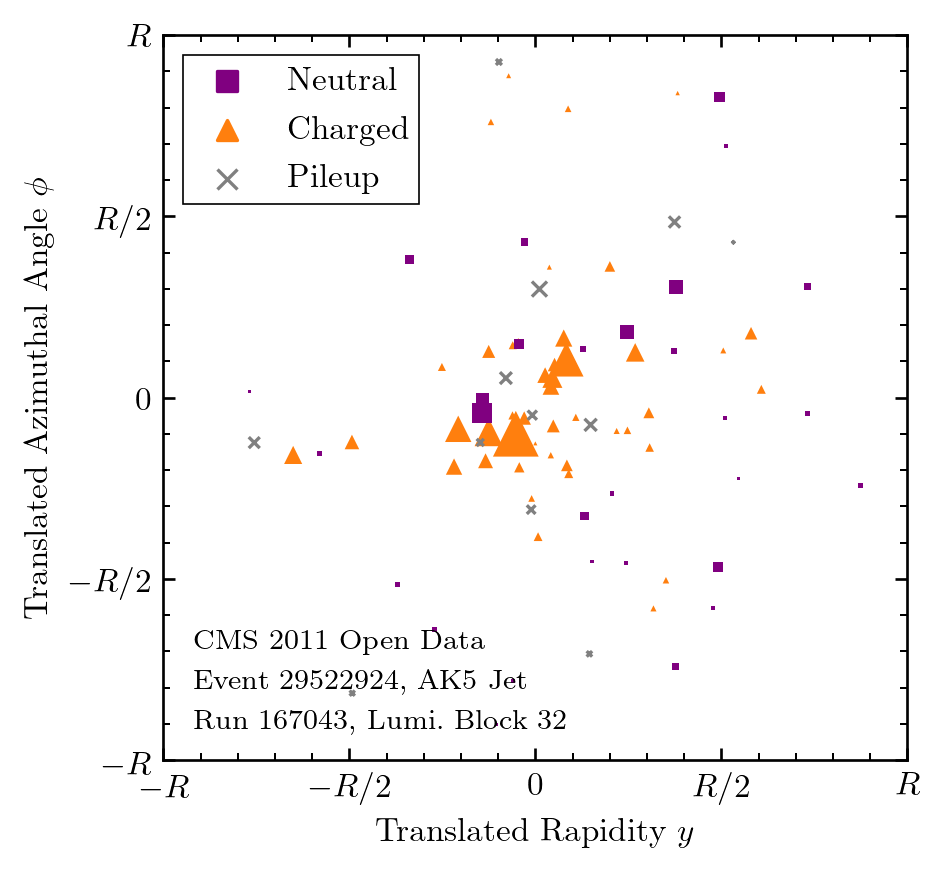

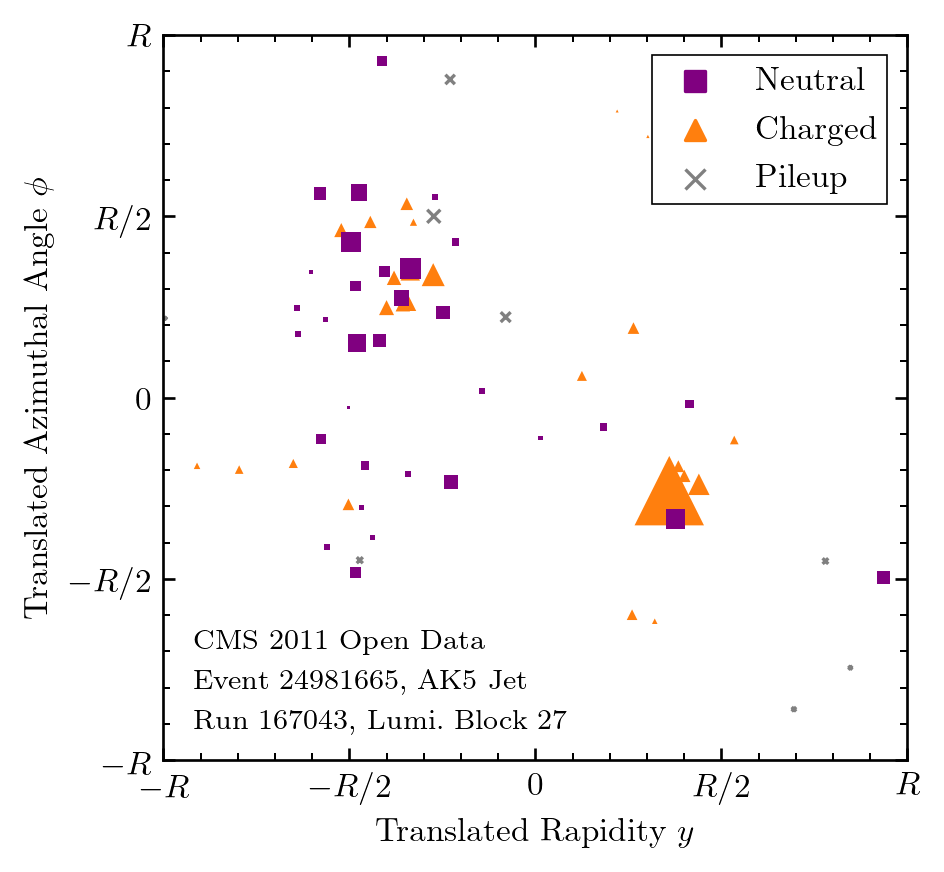

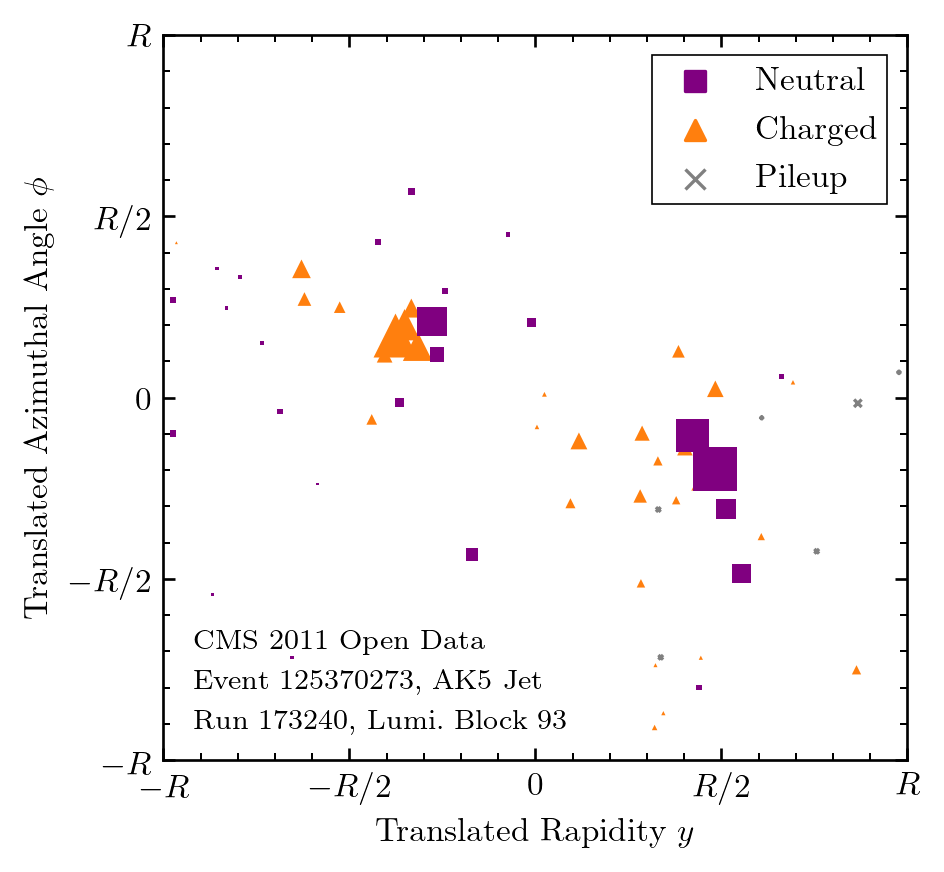

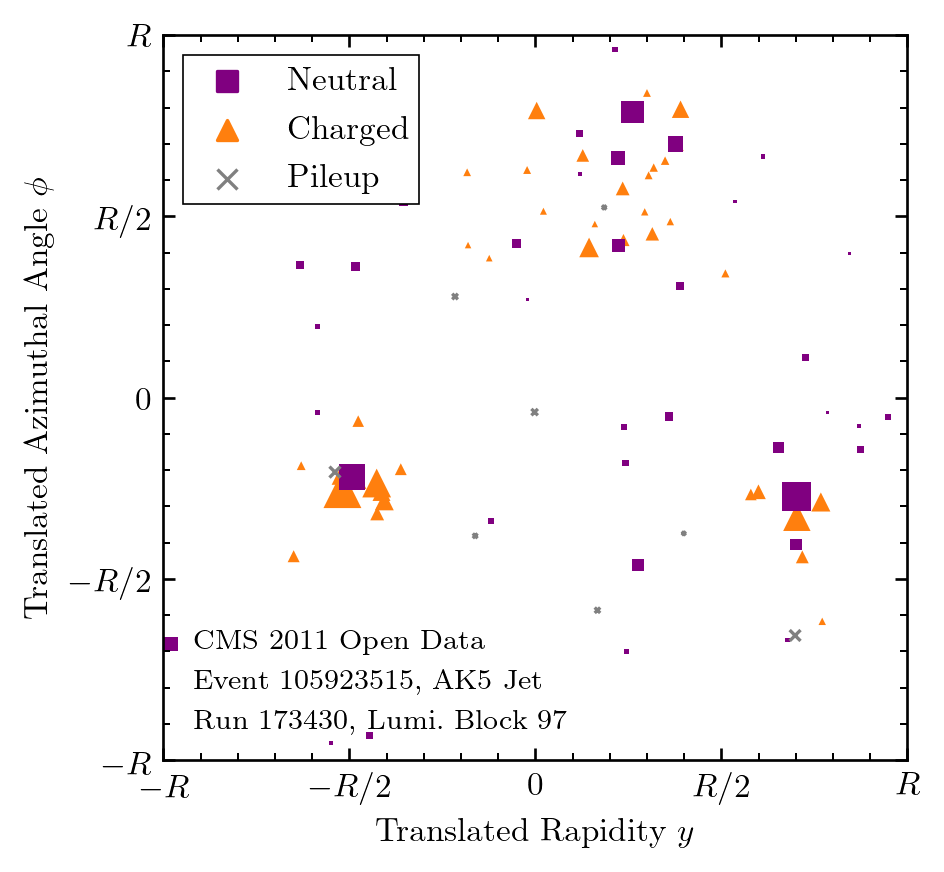

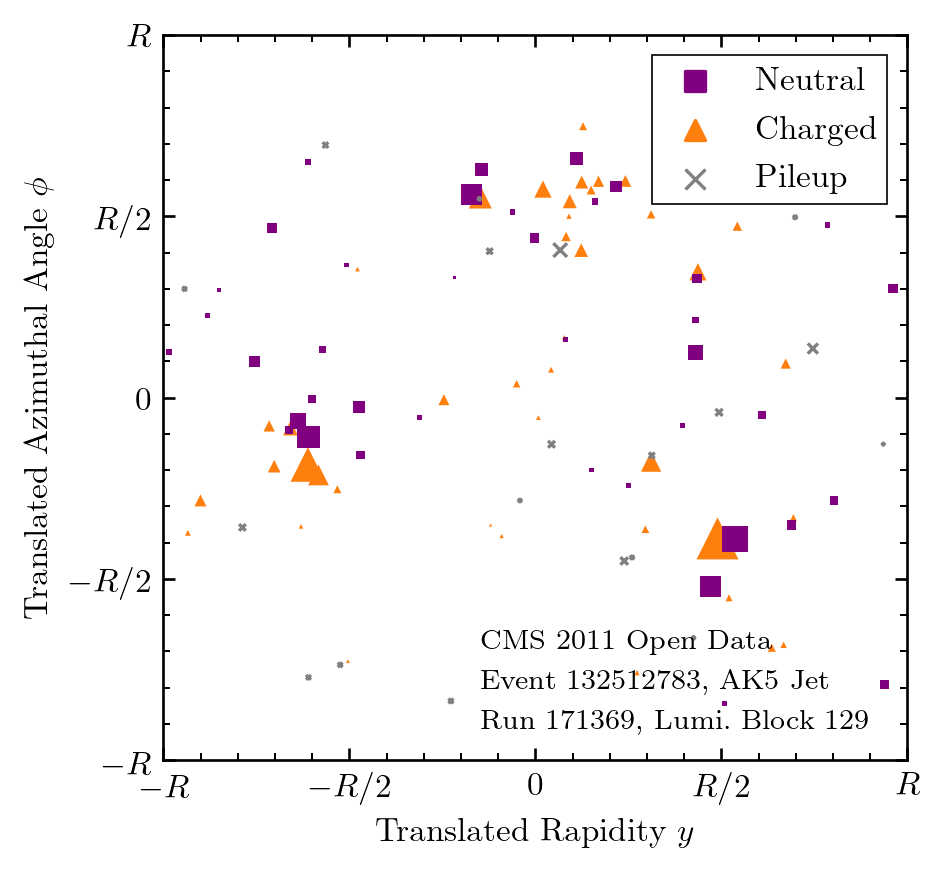

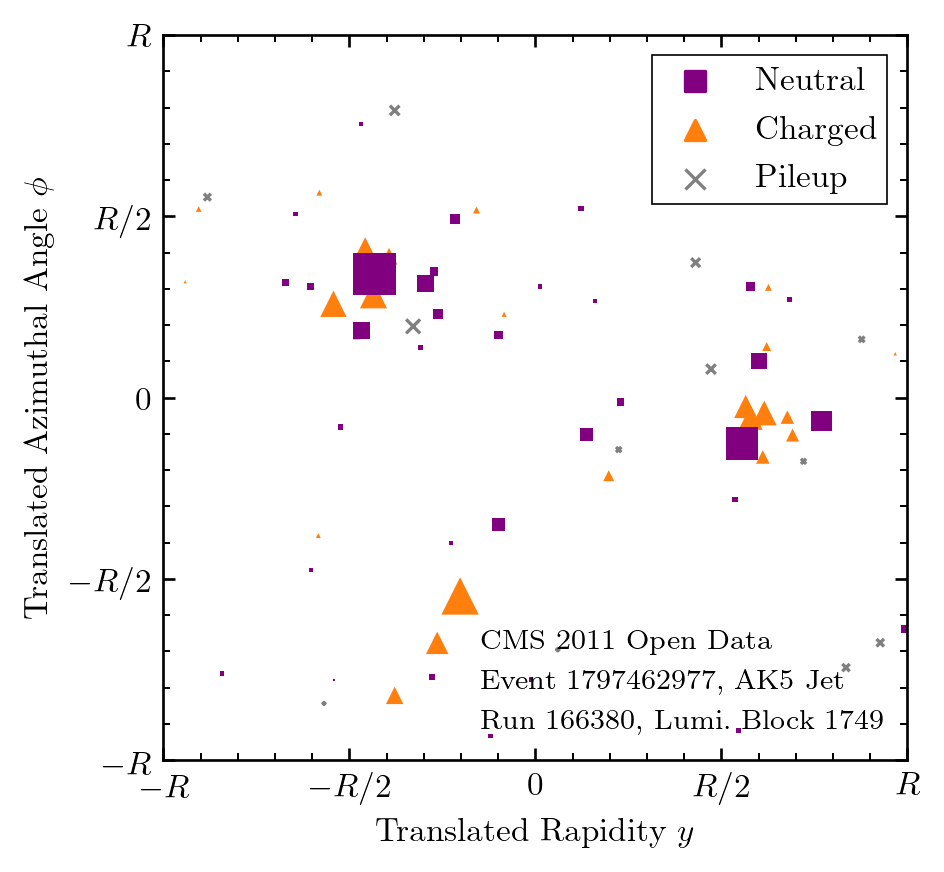

In [3]:
# Plot Individual Jets

# choose interesting events by the event number
evns = [29522924, 24981665, 125370273, 105923515, 132512783, 1797462977]

# specify where to put the legend and the stamp for each jet
leg_locs = ['upper left', 'upper right', 'upper right', 'upper left', 'upper right', 'upper right']
stamplocs = [(0.04, 0.1625), (0.04, 0.1625), (0.04, 0.1625), (0.04, 0.1625), (0.425, 0.1625), (0.425, 0.1625)]

# since there can be two jets with the same event number, have to break the tie
inds = [np.arange(len(cms))[cms.evns == evn][-1 if l<4 else 0] for l,evn in enumerate(evns)]

# jet radius
R = 0.5

# color of charged, neutral, and pileup
chg_col = 'tab:orange'
neu_col = 'purple'
pileup_col = 'gray'

# iterate over the chosen jets
for k, i in enumerate(inds):
        
    # get the list of particles in the the jet
    ev = cms.pfcs[i]
    
    # get the event, run, and lumi block numbers of the jet
    evn, rn, lb = cms.evns[i], cms.rns[i], cms.lbns[i]

    # filter the particles (or not)
    ev = ev[utils.filter_particles(ev, which='all', pt_cut=0, chs=False)]

    # center the jets based on the pT-centroid
    ev = ef.center_ptyphims(ev, center='escheme')

    # scale the jets to 400 GeV
    ev[:,0] *= 400/np.sum(ev[:,0])
    
    # get the axis on which to plot
    fig, axes = modplot.axes(ratio_plot=False, xlim=(-R, R), ylim=(-R, R), 
                             xlabel=r'Translated Rapidity $y$', ylabel=r'Translated Azimuthal Angle $\phi$',
                             xtick_step=0.25, ytick_step=0.25,
                             xticks=[r'$-R$', r'$-R/2$', r'$0$', r'$R/2$', r'$R$'],
                             yticks=[r'$-R$', r'$-R/2$', r'$0$', r'$R/2$', r'$R$'])

    # filters for which particles are charged or CHS or neutral
    chg_filt = utils.filter_particles(ev, which='charged', pt_cut=0, chs=True)
    chs_filt = ~utils.filter_particles(ev, which='all', pt_cut=0, chs=True)
    neu_filt = ~(chg_filt | chs_filt)
    
    # plot the event
    pts, ys, phis = ev[:,0], ev[:,1], ev[:,2]
    
    # sizing factor
    zf = 3
    
    # neutral particles
    axes[0].scatter(ys[neu_filt], phis[neu_filt], marker='s', s=zf*pts[neu_filt], 
                    color=neu_col, lw=0, zorder= -5)
    axes[0].scatter([], [], marker='s', color=neu_col, label='Neutral')
    
    # charged particles
    axes[0].scatter(ys[chg_filt], phis[chg_filt], marker='^', s=zf*pts[chg_filt], 
                    color=chg_col, lw=0, zorder=-10)
    axes[0].scatter([], [], color=chg_col, marker='^', label='Charged')
    
    # CHS particles
    axes[0].scatter(ys[chs_filt], phis[chs_filt], marker='x', s=zf*pts[chs_filt], 
                    color=pileup_col, lw=1, zorder= -5)
    axes[0].scatter([], [], marker='x', lw=1, color=pileup_col, label='Pileup')

    # add plot details
    modplot.stamp(stamplocs[k][0], stamplocs[k][1], delta_y=0.055, line_0='CMS 2011 Open Data',
                  line_1='Event {}, AK5 Jet'.format(evn), line_2=r'Run {}, Lumi.~Block {}'.format(rn,lb))
    
    # add plot legend
    leg = plt.legend(loc=leg_locs[k%len(leg_locs)], frameon=True, edgecolor='black', facecolor='white', 
                     fancybox=False, framealpha=1.0).get_frame()
    leg.set_linewidth(0.5)
    leg.set_boxstyle('square', pad=-0.1)
    
    # save plot
    if save_plots:
        modplot.save(fig, 'Jet_{}_Display'.format(evn), tx=48, ty=252.5, out_plots_dir='../plots/EventDisplays')
        
    fig.show()

## Display of EMD between Jets

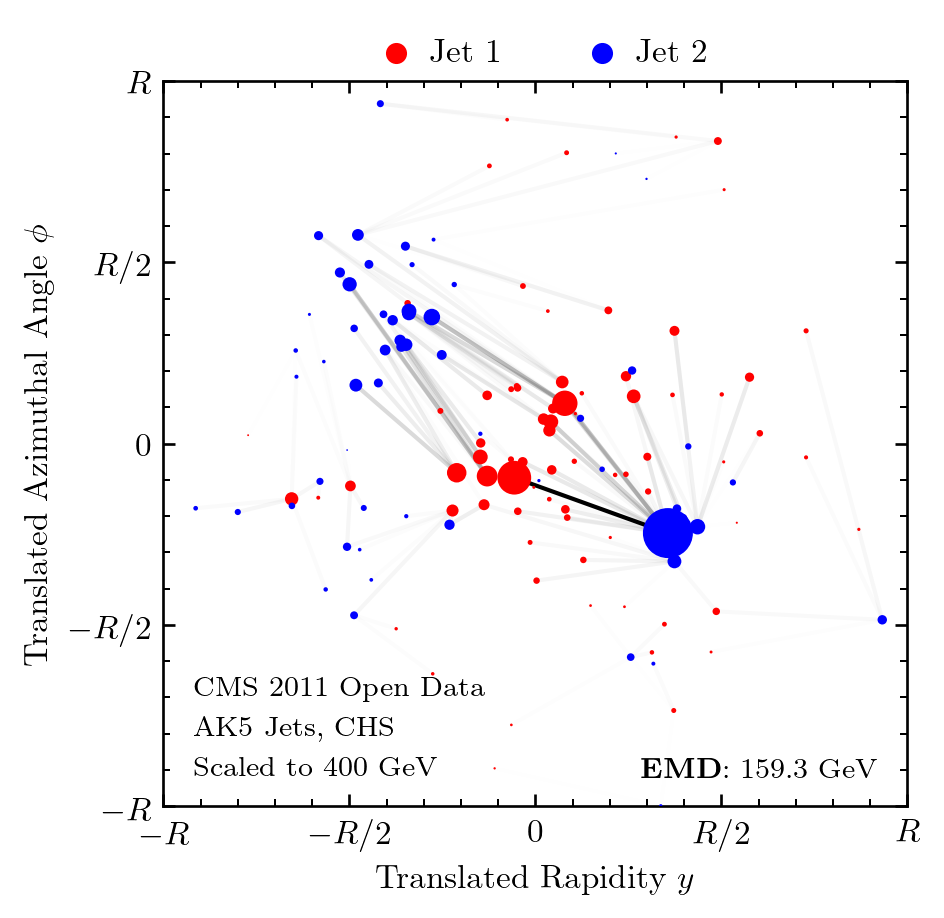

In [4]:
# Plot the Optimal Transport between Jets

# choose interesting jets based on the event number
evn0, evn1 = 29522924, 24981665

# since there can be two jets with the same event number, have to break the tie
i0 = np.arange(len(cms))[cms.evns == evn0][-1]
i1 = np.arange(len(cms))[cms.evns == evn1][-1]

# get the list of particles of the two jets
ev0, ev1 = cms.pfcs[i0], cms.pfcs[i1]

# filter the particles (or not)
ev0 = ev0[utils.filter_particles(ev0, which='all', pt_cut=0, chs=True)]
ev1 = ev1[utils.filter_particles(ev1, which='all', pt_cut=0, chs=True)]

# rotate the jets if desired
#ev0 = ef.rotate_ptyphims(ev0, scheme='ptscheme', center='escheme')
#ev1 = ef.rotate_ptyphims(ev1, scheme='ptscheme', center='escheme')

# center the jets
ev0 = ef.center_ptyphims(ev0, center='escheme')
ev1 = ef.center_ptyphims(ev1, center='escheme')

# scale the jets to 400 GeV
ev0[:,0] *= 400/np.sum(ev0[:,0])
ev1[:,0] *= 400/np.sum(ev1[:,0])

# calculate the EMD and the optimal transport flow
R = 0.5
emdval, G = emd(ev0, ev1, R=R, gdim=2, return_flow=True)

# get the axis on which to plot
fig, axes = modplot.axes(ratio_plot=False, xlim=(-R, R), ylim=(-R, R), 
                         xlabel=r'Translated Rapidity $y$', ylabel=r'Translated Azimuthal Angle $\phi$',
                         xtick_step=0.25, ytick_step=0.25,
                         xticks=[r'$-R$', r'$-R/2$', r'$0$', r'$R/2$', r'$R$'],
                         yticks=[r'$-R$', r'$-R/2$', r'$0$', r'$R/2$', r'$R$'])

# plot the two events
zf = 1.5
colors = ['red', 'blue']
labels = ['Jet 1', 'Jet 2']
for i,ev in enumerate([ev0, ev1]):
    pts, ys, phis = ev[:,0], ev[:,1], ev[:,2]
    axes[0].scatter(ys, phis, marker='o', s=zf*pts, color=colors[i], lw=0, zorder=10, label=labels[i])

# plot the flow
mx = G.max()
xs, xt = ev0[:,1:3], ev1[:,1:3]
for i in range(xs.shape[0]):
    for j in range(xt.shape[0]):
        if G[i, j] > 0:
            axes[0].plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]],
                     alpha=G[i, j]/mx, lw=1.25, color='black')

# add plot details
axes[0].text(0.64, 0.04, r'{\bf EMD}'+': {:.1f} GeV'.format(emdval), 
             fontsize=8.5, transform=plt.gca().transAxes)
lgnd = plt.legend(loc=(0.25, 1.0), frameon=False, ncol=2, handletextpad=0)
modplot.stamp(0.04, 0.1625, delta_y=0.055, line_0='CMS 2011 Open Data',
              line_1=r'AK5 Jets, CHS', line_2='Scaled to 400 GeV')

# make marker sizes standard in legend
lgnd.legendHandles[0]._sizes = [40]
lgnd.legendHandles[1]._sizes = [40]

# save plot
if save_plots:
    modplot.save(fig, 'Jet_{}_{}_EMD'.format(evn0,evn1), tx=48, ty=252, out_plots_dir='../plots/EventDisplays/')

fig.show()

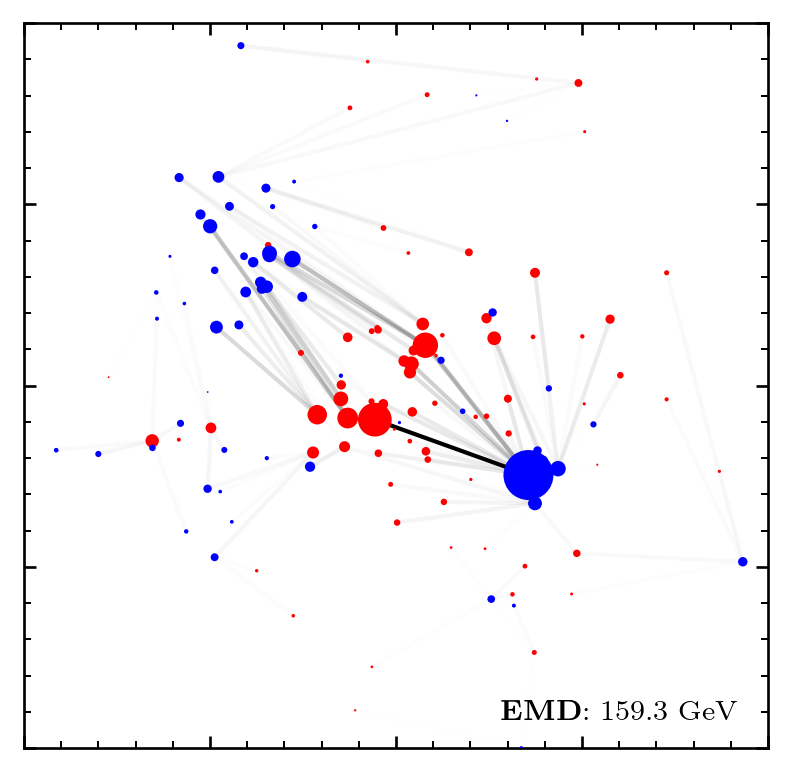

In [23]:
# Plot the Optimal Transport between Jets

# choose interesting jets based on the event number
evn0, evn1 = 29522924, 24981665

# since there can be two jets with the same event number, have to break the tie
i0 = np.arange(len(cms))[cms.evns == evn0][-1]
i1 = np.arange(len(cms))[cms.evns == evn1][-1]

# get the list of particles of the two jets
ev0, ev1 = cms.pfcs[i0], cms.pfcs[i1]

# filter the particles (or not)
ev0 = ev0[utils.filter_particles(ev0, which='all', pt_cut=0, chs=True)]
ev1 = ev1[utils.filter_particles(ev1, which='all', pt_cut=0, chs=True)]

# rotate the jets if desired
#ev0 = ef.rotate_ptyphims(ev0, scheme='ptscheme', center='escheme')
#ev1 = ef.rotate_ptyphims(ev1, scheme='ptscheme', center='escheme')

# center the jets
ev0 = ef.center_ptyphims(ev0, center='escheme')
ev1 = ef.center_ptyphims(ev1, center='escheme')

# scale the jets to 400 GeV
ev0[:,0] *= 400/np.sum(ev0[:,0])
ev1[:,0] *= 400/np.sum(ev1[:,0])

# calculate the EMD and the optimal transport flow
R = 0.5
emdval, G = emd(ev0, ev1, R=R, gdim=2, return_flow=True)

# get the axis on which to plot
fig, axes = modplot.axes(ratio_plot=False, xlim=(-R, R), ylim=(-R, R), 
                         xlabel=r'', ylabel=r'',
                         xtick_step=0.25, ytick_step=0.25,
                         xticks=[],
                         yticks=[])

# plot the two events
zf = 1.5
colors = ['red', 'blue']
labels = ['Jet 1', 'Jet 2']
for i,ev in enumerate([ev0, ev1]):
    pts, ys, phis = ev[:,0], ev[:,1], ev[:,2]
    axes[0].scatter(ys, phis, marker='o', s=zf*pts, color=colors[i], lw=0, zorder=10, label=labels[i])

# plot the flow
mx = G.max()
xs, xt = ev0[:,1:3], ev1[:,1:3]
for i in range(xs.shape[0]):
    for j in range(xt.shape[0]):
        if G[i, j] > 0:
            axes[0].plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]],
                     alpha=G[i, j]/mx, lw=1.25, color='black')

axes[0].text(0.64, 0.04, r'{\bf EMD}'+': {:.1f} GeV'.format(emdval), 
             fontsize=8.5, transform=plt.gca().transAxes)
            
# save plot
if save_plots or 1:
    modplot.save(fig, 'JetCustom_{}_{}_EMD'.format(evn0,evn1), tx=13, ty=199, out_plots_dir='../plots/EventDisplays/')

fig.show()

## Full Event Displays (requires full MOD file)

In [5]:
# Note that the full event display requires the full MOD file rather than the processed jet dataset
# which MOD file to read in
file = mod_io.MODReader('0C0C31A2-273F-E311-A679-02163E00B023', dataset='cms', store_particles=True)
ak5s, pfcs = file.ak5s, file.pfcs
good_inds = [i for i in range(1000) if pfcs[i].size and ak5s[i][0,1] > 350]

Jet pT: 388.63952418122403
Jet pT: 375.2604464086835


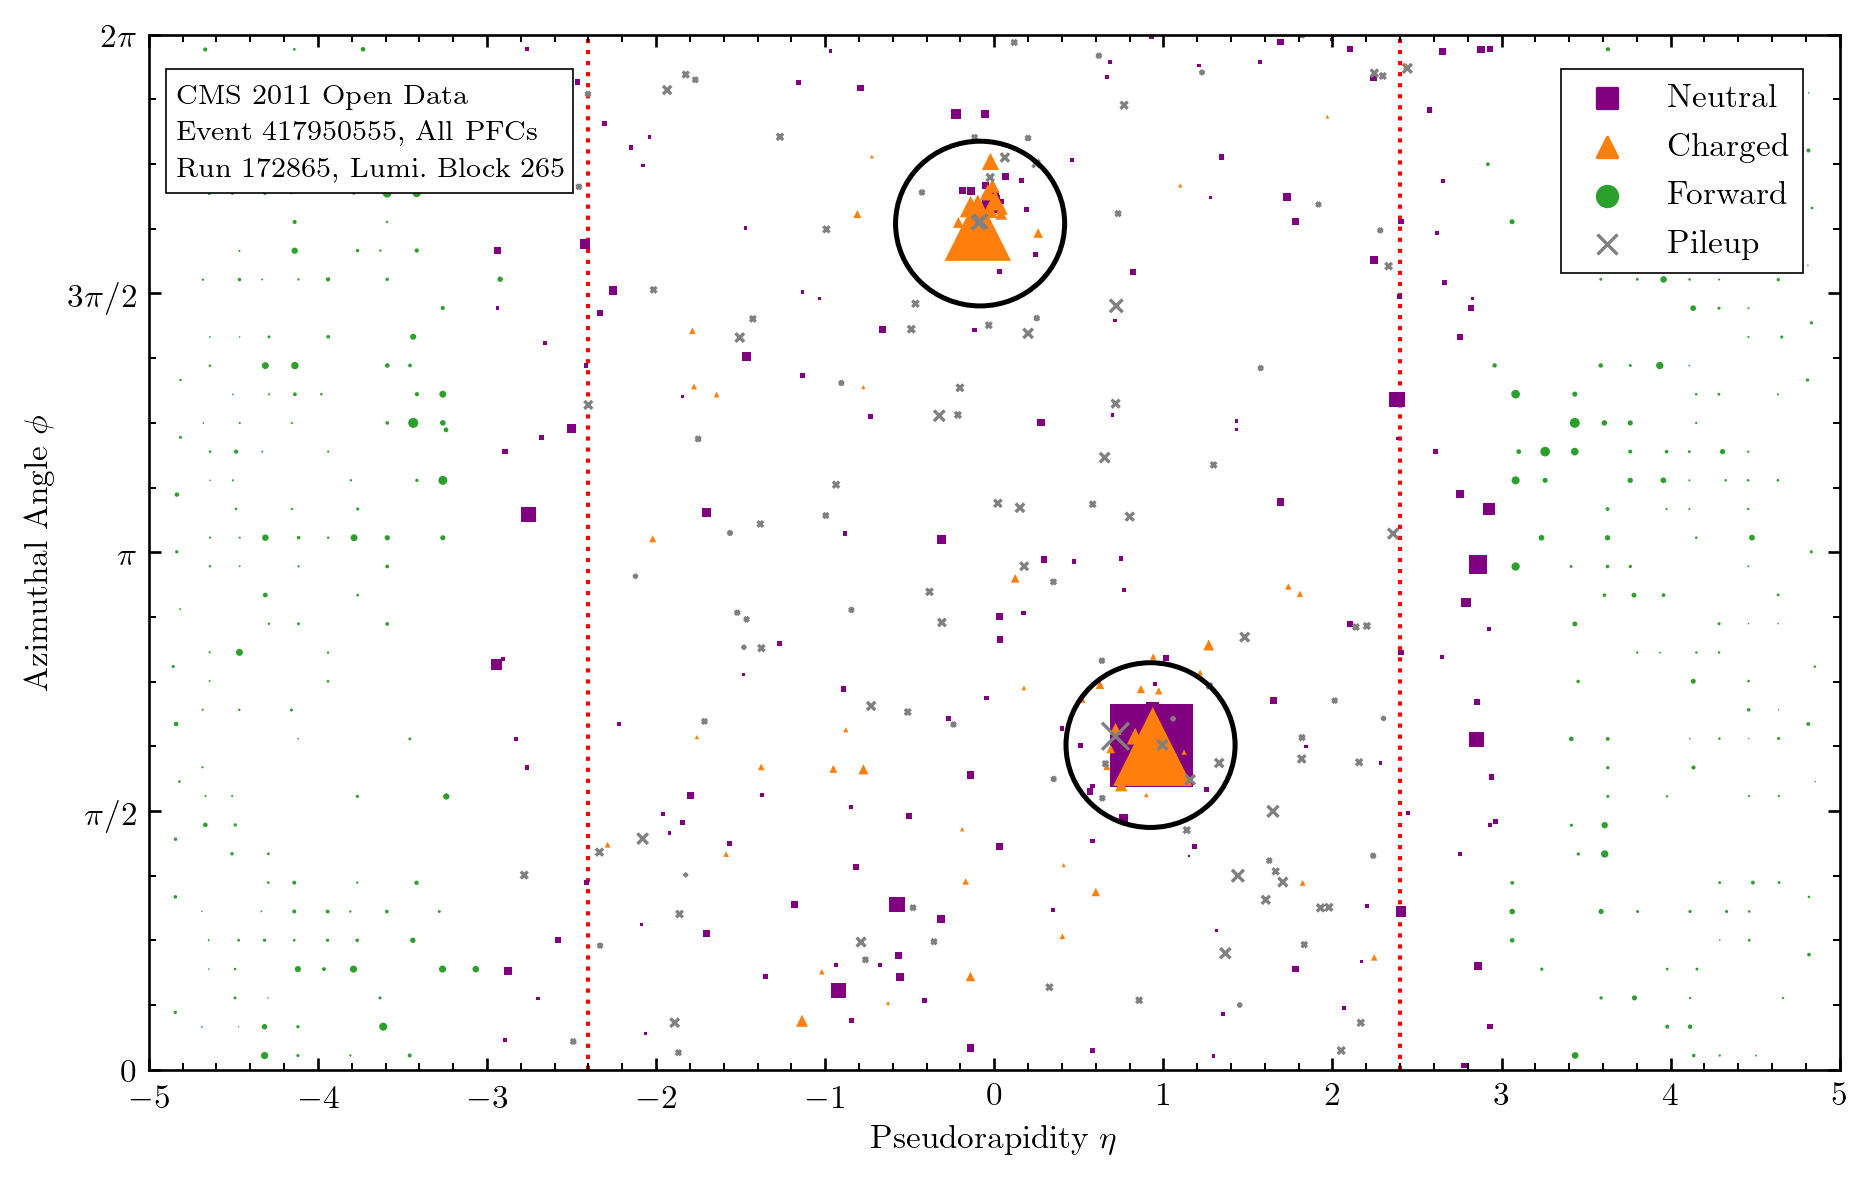

In [6]:
# choose event
i = 39
n = good_inds[i]

# event info
evn = file.data['evns'][n]
rn = file.data['lbs'][file.data['lbs_i'][n]]['rn']
lb = file.data['lbs'][file.data['lbs_i'][n]]['lb']

3# get mod axes
scale = 1.1
fig, axes = modplot.axes(ratio_plot=False, xlim=(-5,5), ylim=(0,2*np.pi), figsize=(10/scale, 2*np.pi/scale),
                         xlabel=r'Pseudorapidity $\eta$', ylabel=r'Azimuthal Angle $\phi$', xtick_step=1)

# get the pfc information and convert to eta
pts, ys, phis, ms = ef.ptyphims_from_p4s(pfcs[n][:,[3,0,1,2]]).T
etas = ef.etas_from_pts_ys_ms(pts, ys, ms)
pids = pfcs[n][:,4]

# determine particle types
nopu_filt = (pfcs[n][:,5] <= 0)
forw_filt = nopu_filt & (np.abs(pids) <= 2)
chrg_filt = nopu_filt & ~forw_filt & ef.ischrgd(pids)
neut_filt = nopu_filt & ~forw_filt & ~ef.ischrgd(pids)

# jet radius
R = 0.5

# size for plot style
zf = 5

# plot neutrals
axes[0].scatter(etas[neut_filt], phis[neut_filt], s=zf*pts[neut_filt], color='purple', marker='s', lw=0)
axes[0].scatter([], [], marker='s', color='purple', label='Neutral')

# plot chargeds
axes[0].scatter(etas[chrg_filt], phis[chrg_filt], s=zf*pts[chrg_filt], color='tab:orange', marker='^', lw=0)
axes[0].scatter([], [], marker='^', color='tab:orange', label='Charged')

# plot forwards
axes[0].scatter(etas[forw_filt], phis[forw_filt], s=zf*pts[forw_filt], color='tab:green', marker='o', lw=0)
axes[0].scatter([], [], marker='o', color='tab:green', label='Forward')

# plot pileup
axes[0].scatter(etas[~nopu_filt], phis[~nopu_filt], s=zf*pts[~nopu_filt], color='gray', marker='x', lw=1)
axes[0].scatter([], [], marker='x', lw=1, color='gray', label='Pileup')

# apply JECs
pts_corrected = ak5s[n][:,1] * ak5s[n][:,5]
argsort = np.argsort(pts_corrected)[::-1]

# show and print the leading two AK5 jets
for i in argsort[:2]:
    jet_pt, jet_eta, jet_phi, jet_m, jet_jec = ak5s[n][i,1:6]
    jet_phi %= 2*np.pi
    
    print("Jet pT:", jet_pt * jet_jec)
    axes[0].add_artist(matplotlib.patches.Circle([jet_eta, jet_phi], R, fill=None, edgecolor='black', lw=1.5))
    
# show |eta|=2.4 lines
plt.plot([-2.4,-2.4], [0, 2*np.pi], color='red',lw=1.25, ls=':', zorder=-10)
plt.plot([2.4,2.4], [0, 2*np.pi], color='red', lw=1.25, ls=':', zorder=-10)
    
# put the y axis ticks in terms of pi
axes[0].set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
axes[0].set_yticklabels([r'$0$',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])

# use latex for minus signs on xticks
axes[0].set_xticks(np.arange(-5,6))
axes[0].set_xticklabels([r'$-5$',r'$-4$',r'$-3$',r'$-2$',r'$-1$',r'$0$',r'$1$',r'$2$',r'$3$',r'$4$',r'$5$'])
    
# add legend
leg = plt.legend(loc=(.835, .77), frameon=True, edgecolor='black', facecolor='white', 
                     fancybox=False, framealpha=1.0).get_frame()
leg.set_linewidth(0.5)    
axes[0].add_artist(matplotlib.patches.Rectangle([-4.9,5.325], 2.41, 0.75, 
                                                facecolor='white', edgecolor='black', lw=0.5))

# add stamp
modplot.stamp(0.016, 0.94, delta_y=0.035, line_0='CMS 2011 Open Data',
              line_1='Event {}, All PFCs'.format(evn), line_2=r'Run {}, Lumi.~Block {}'.format(rn,lb))

# save plot
modplot.save(fig, 'Event_{}_Display'.format(evn), tx=43.75, ty=344.25, out_plots_dir='../plots/EventDisplays')
    
fig.show()